In [2]:
import pandas as pd
import numpy as np
import os


In [3]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_ori.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_ori.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_ori.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_ori.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_ori.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_ori.pkl")

In [4]:
X_train

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll
634004,-0.458843,-0.004343,-0.272226,0.032586,-0.057479,0.017799,0.151812,-0.795093,-1.048645
634005,-0.881271,0.789259,-0.322166,0.031217,-0.012802,-0.002940,0.136114,-0.778771,-0.997640
634006,-0.750800,0.547177,-0.330515,0.042022,0.011359,-0.011404,0.121327,-0.765772,-0.956557
634007,-0.640295,0.394234,-0.315634,0.030857,0.012073,-0.015476,0.108499,-0.754728,-0.921267
634008,-0.686538,0.550332,-0.359439,0.009593,0.003928,-0.010498,0.098456,-0.744377,-0.889684
...,...,...,...,...,...,...,...,...,...
109057760,0.450731,0.535045,-0.324386,-0.031796,-0.059572,-0.027028,-0.127635,-0.706084,0.517298
109057761,0.481948,0.536976,-0.334319,-0.016996,-0.046264,-0.028323,-0.126733,-0.705844,0.516299
109057762,0.502064,0.539007,-0.333029,0.000452,-0.029247,-0.023712,-0.126094,-0.706144,0.516886
109057763,0.498980,0.536931,-0.329682,0.008017,-0.019459,-0.027067,-0.125563,-0.706848,0.518772


In [6]:
y_train

96879      STD
96880      STD
96881      STD
96882      STD
96883      STD
          ... 
4138422    STD
4138423    STD
4138424    STD
4138425    STD
4138426    STD
Name: label, Length: 2781516, dtype: object

### Segment into Windows

In [6]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

def create_windows(X, y, window_size=125, step_size=62): # 2.5 sec with 50% overlapping window
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [7]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [11]:
X_train_windows.shape

(44862, 125, 9)

In [13]:
y_train.value_counts()

label
STD    835917
WAL    796118
JOG    194401
JUM    188383
SIT    182281
LYI    176995
STU    109644
STN     99183
CSO     52734
CSI     48532
SCH     27219
BSC     18513
SDL     16170
FKL     15241
FOL     13680
CHU      6505
Name: count, dtype: int64

### Encode Label

In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])
num_classes = len(set(y_train_windows_encoded))  

model = Sequential([
    # First convolutional block
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    # Second convolutional block
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    # Third convolutional block
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    # Fourth convolutional block
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    
    # Flatten before Dense
    Flatten(),
    
    # First fully connected (dense) block
    Dropout(0.5),
    Dense(128, activation='relu'),
    
     # Second fully connected (dense) block
    Dropout(0.5),
    Dense(128, activation='relu'),
    
    # Final output layer
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
    
# Compile the model with a common optimizer and loss function for classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 121, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 117, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 113, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 109, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6976)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6976)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       893,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 976,208 (3.72 MB)

 Trainable params: 976,208 (3.72 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6608 - loss: 1.1128 - val_accuracy: 0.8044 - val_loss: 0.6250
Epoch 2/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8470 - loss: 0.4702 - val_accuracy: 0.7657 - val_loss: 0.6770
Epoch 3/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8721 - loss: 0.4050 - val_accuracy: 0.7899 - val_loss: 0.6347
Epoch 4/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8826 - loss: 0.3677 - val_accuracy: 0.7810 - val_loss: 0.6414
Epoch 5/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8922 - loss: 0.3400 - val_accuracy: 0.7760 - val_loss: 0.6769
Epoch 6/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8977 - loss: 0.3269 - val_accuracy: 0.7595 - val_loss: 0.7261
Epoch 7/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9060 - loss: 0.3085 - val_accuracy: 0.8079 - val_loss: 0.6120
Epoch 8/25
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9080 -

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.9621
Test Accuracy: 0.8082
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


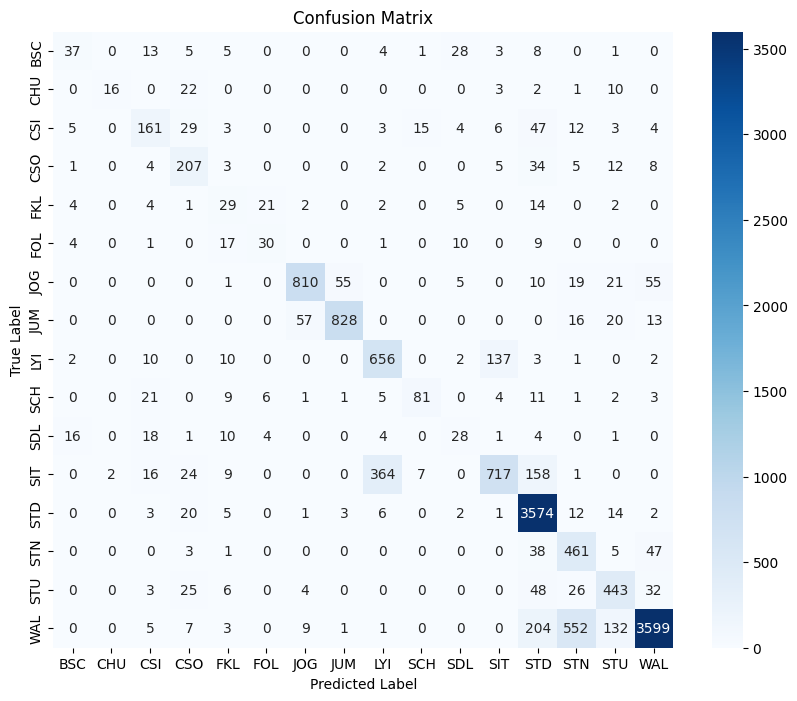

Classification Report:
               precision    recall  f1-score   support

         BSC       0.54      0.35      0.43       105
         CHU       0.89      0.30      0.44        54
         CSI       0.62      0.55      0.58       292
         CSO       0.60      0.74      0.66       281
         FKL       0.26      0.35      0.30        84
         FOL       0.49      0.42      0.45        72
         JOG       0.92      0.83      0.87       976
         JUM       0.93      0.89      0.91       934
         LYI       0.63      0.80      0.70       823
         SCH       0.78      0.56      0.65       145
         SDL       0.33      0.32      0.33        87
         SIT       0.82      0.55      0.66      1298
         STD       0.86      0.98      0.92      3643
         STN       0.42      0.83      0.55       555
         STU       0.67      0.75      0.71       587
         WAL       0.96      0.80      0.87      4513

    accuracy                           0.81     14449
  

In [20]:
label_classes = le.classes_.tolist()

metrics = evaluate_model(model, X_test_windows, y_test_windows_encoded, label_classes=label_classes)


### 10-Fold Cross Validation

In [15]:
from sklearn.model_selection import GroupKFold

In [16]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [17]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)
    

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")


KeyboardInterrupt: 